In [56]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import scipy.stats as ss
from tqdm.auto import tqdm

In [57]:
# считывание данных
data = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-romanova-28/statistics/hw_aa.csv", sep=';', index_col=0)

Посмотрим на данные

In [58]:
data

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [59]:
data.isna().sum()

uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

Запустим A/A-тест

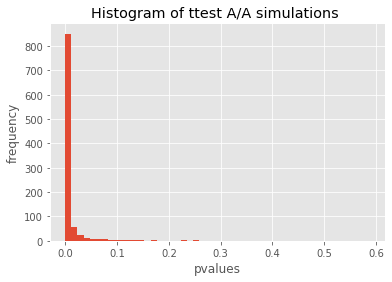

0.946

In [60]:
n = 100000
simulations = 1000
n_s = 1000
res = []

df = pd.DataFrame({
    "s1": np.random.exponential(scale=1/0.001, size=n),
    "s2": np.random.exponential(scale=1/0.001, size=n)
})

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = data[data.experimentVariant == 0].purchase.sample(n_s, replace = False).values
    s2 = data[data.experimentVariant == 1].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

FPR > 0,05 и распределение выглядит очень неоднородным, следовательно сплит-система работает некорректно

Посмотрим на количество пользователей в вариантах эксперимента

In [61]:
data.groupby('experimentVariant', as_index=False).agg({'uid':'count'})

,experimentVariant,uid
0,0,63102
1,1,63916


Посмотрим на конверсию, группируя по варианту и версии приложения 

In [62]:
data.groupby(['experimentVariant', 'version'], as_index=False) \
    .agg({'uid':'count', 'purchase':'mean'})

,experimentVariant,version,uid,purchase
0,0,v2.8.0,41283,0.000993
1,0,v2.9.0,11921,0.074658
2,0,v3.7.4.0,4204,0.059943
3,0,v3.8.0.0,5694,0.057604
4,1,v2.8.0,41552,0.045606
5,1,v2.9.0,12033,0.071304
6,1,v3.7.4.0,4221,0.063018
7,1,v3.8.0.0,6110,0.062848


Видно, что конверсия в группах 0 и 1 у версии приложения v2.8.0 отличаются: 0,099% и 4,5% соответственно, у остальных групп примерно значения одинаковые. 

In [63]:
# распределение количества пользователей, совершивших или нет покупку, по вариантам эксперимента и версии приложения 
data.groupby(['version', 'experimentVariant','purchase']).agg({'uid':'count'})

uid
version  experimentVariant purchase       
v2.8.0   0                 0         41242
                           1            41
         1                 0         39657
                           1          1895
v2.9.0   0                 0         11031
                           1           890
         1                 0         11175
                           1           858
v3.7.4.0 0                 0          3952
                           1           252
         1                 0          3955
                           1           266
v3.8.0.0 0                 0          5366
                           1           328
         1                 0          5726
                           1           384

Посмотрим насколько значимы различия в группах

Сначала проверим условия применения t-теста 
1. Распределение признаков в каждой выборке соответствует нормальному распределению
2. Дисперсии признака в выборках примерно равны

Условие нормальности распределения данных становится не таким жестким при "больших" объемах выборок, так что проверять будем только второе условие тестом Левена (H0 - дисперсии гомогенны)

In [64]:
ss.levene(data[(data.experimentVariant == 0) & (data.version=='v2.8.0')].purchase, 
          data[(data.experimentVariant == 1) & (data.version=='v2.8.0')].purchase)

LeveneResult(statistic=1845.86584154131, pvalue=0.0)

In [65]:
ss.levene(data[(data.experimentVariant == 0) & (data.version=='v2.9.0')].purchase, 
          data[(data.experimentVariant == 1) & (data.version=='v2.9.0')].purchase)

LeveneResult(statistic=0.9959236895574869, pvalue=0.31830895168552764)

In [66]:
ss.levene(data[(data.experimentVariant == 0) & (data.version=='v3.7.4.0')].purchase, 
          data[(data.experimentVariant == 1) & (data.version=='v3.7.4.0')].purchase)

LeveneResult(statistic=0.34514753748725946, pvalue=0.5568886771102542)

In [67]:
ss.levene(data[(data.experimentVariant == 0) & (data.version=='v3.8.0.0')].purchase, 
          data[(data.experimentVariant == 1) & (data.version=='v3.8.0.0')].purchase)

LeveneResult(statistic=1.4295045421304666, pvalue=0.2318693366410811)

По результатам теста принимаем альтернативную гипотезу - дисперсии гетерогенны (различаются) в случае v2.8.0 и используем модификацию t-критерия (критерий Уэлча) (H0 - средние не различаются), для остальных версий приложения принимаем нулевую гипотезу и используем обычный t-критерий.

Проводим t-тест

In [68]:
stats.ttest_ind(data[(data.experimentVariant == 0) & (data.version=='v2.8.0')].purchase, 
                data[(data.experimentVariant == 1) & (data.version=='v2.8.0')].purchase, equal_var = False)

Ttest_indResult(statistic=-43.097051598551076, pvalue=0.0)

In [69]:
stats.ttest_ind(data[(data.experimentVariant == 0) & (data.version=='v2.9.0')].purchase, 
                data[(data.experimentVariant == 1) & (data.version=='v2.9.0')].purchase)

Ttest_indResult(statistic=0.9979597634962479, pvalue=0.31830895167207446)

In [70]:
stats.ttest_ind(data[(data.experimentVariant == 0) & (data.version=='v3.7.4.0')].purchase, 
                data[(data.experimentVariant == 1) & (data.version=='v3.7.4.0')].purchase)

Ttest_indResult(statistic=-0.5874925850487471, pvalue=0.5568886771079735)

In [71]:
stats.ttest_ind(data[(data.experimentVariant == 0) & (data.version=='v3.8.0.0')].purchase, 
                data[(data.experimentVariant == 1) & (data.version=='v3.8.0.0')].purchase)

Ttest_indResult(statistic=-1.1956188950206779, pvalue=0.23186933664059722)

Значение меньше 0.05 в случае v2.8.0, поэтому мы отклоняем нулевую гипотезу и делаем вывод, что средние в группах значимо различаются.
В остальных выборках средние в группах не различаются.

Исключим из исходных данных информацию по версии приложения v2.8.0	и снова проведем А/А тест

In [72]:
df_1 = data.query('version != "v2.8.0"')

In [73]:
df_1.version.unique()

array(['v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

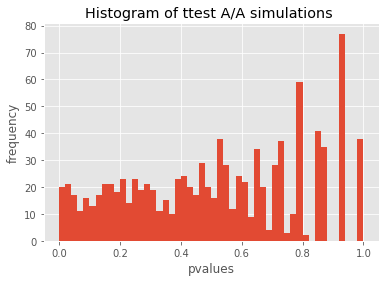

0.049

In [74]:
n = 100000
simulations = 1000
n_s = 1000
res = []

df = pd.DataFrame({
    "s1": np.random.exponential(scale=1/0.001, size=n),
    "s2": np.random.exponential(scale=1/0.001, size=n)
})

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_1[df_1.experimentVariant == 0].purchase.sample(n_s, replace = False).values
    s2 = df_1[df_1.experimentVariant == 1].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

FPR меньше 0,05 и само распределение выглядит намного лучше предыдущего. Делаем вывод, что сплит-система действительно сломана, а именно неккоректно осуществляется разделение пользователей внутри версии приложения v2.8.0 (количество пользователей, совершивших покупку, сильно отличаются в вариантах эксперимента).